In [78]:
# This code uses a Pokemon's stats, metrics (weight, height),ability, and generation to attempt to predict their Types
# One of the best predictors for Pokemon Type is physical color, data that is not present in this data set
# For example, many 'Fire' Type Pokemon will be Red or Orange, 'Water' Type Pokemon will be Blue, etc.
# As such, the classifier model will be far from a perfect fit.
# However, it is also demonstrated that Pokemon types tend to follow particular distribution of stats
# For example, 'Electric' Types will tend to have higher Speed stats, 'Steel' Types will tend to have higher Defense stats, etc.

# To begin, let's import all the necessary modules and their derivative classes
# These modules have been specially developed for wrangling visualizing, and modeling data
import pandas as pd  # used for DataFrames, Series, and reading in .csv files
import matplotlib  # used for visualizations
import matplotlib.pyplot as plt  # used to make really cool graphs
import random as rd  # used to generate random results when needed - can be seeded to reproduce results
import numpy as np  # used for arrays and vectorization 
from sklearn.tree import DecisionTreeRegressor  # used to build our decision tree model
# matplotlib.style.use('ggplot')  # use ggplot style for matplot visualizations, I prefer seaborn (below)
plt.style.use('seaborn-darkgrid')  # use seaborn for matplot visualizations, feel free to use ggplot instead
my_dpi=96  # adjust dpi
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)  # adjust plot size
rd.seed(151)  # seed used to replicate results - not needed if you aren't wanting replication

<Figure size 480x480 with 0 Axes>

In [79]:
# The first thing we need to do is load the data into our notebook so we can begin to analyze it
# Using pandas, we can create a DataFrame from the csv 
df = pd.read_csv('Documents/GitHub/Pokemon_Projects/Type_Classification/pokemon_complete.csv')  # read in csv of complete Pokemon data for generations 1-7
df.head()  # we can see the 'head' of the DataFrame - the first 5 rows of data

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


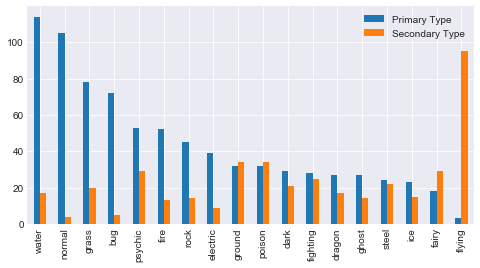

In [80]:
# Before creating a model, let's check out the distribution of Primary and Secondary Types
graph_df = df['type1'].value_counts().rename('Primary Type').to_frame().\
    join(df['type2'].value_counts().rename('Secondary Type').to_frame())

graph_df.plot(kind='bar',figsize=(8, 4))

# We can see the overall distribution of Primary and Secondary Types here
# Interesting to note, certain types like Water, Normal, Grass, and Bug tend to be Primary Types and rarely Secondary Types
# On the contrary, Flying type is rarely a Primary Type and almost exlusively is a Secondary Type
# Finally, types such as Poison, Ground, Fighting, and Steel exhibit an even distribution for Primary and Secondary Types

In [81]:
# Programatically map Type1 and Type2 (strings) to integer representation - i.e. Grass -> 1, Ghost -> 13, etc.
# Also create a list that holds the mappings, useful to reference later
counter = 1
type_map = [(np.nan, 0)]  # mapping of types, initialized - when printed, will show the full integer->Type mapping
target1, target2 = df['type1'], df['type2'].replace(np.nan, 0)
for x in df['type1'].unique():
    type_map.append((x, counter))
    target1 = target1.replace(x, counter)
    target2 = target2.replace(x, counter)
    counter = counter + 1

In [82]:
# Programatically map Abilities (array<strings>) to integer representation - i.e. Overgrow -> 2, Blaze -> 2, etc.
# Also create a list that holds the mappings, useful to reference later

# First, we need to edit indexes with more than 1 ability - we are only modeling using the default abilities
# i.e. Venusaur has ['Overgrow', 'Chlorophyll'], so we will remove all abilities other than the default (Overgrow)

abilities = []
for x in df['abilities']:
    default_ability = x.split(",")[0]
    abilities.append(''.join([i for i in default_ability if i.isalpha()]))
df['abilities'] = abilities

# Similar to the Type->integer mapping above
counter = 1
ability_map = []  # mapping of abilities, initialized - when printed, will show the full integer->Ability mapping
abilities = df['abilities']
for x in df['abilities'].unique():
    ability_map.append((x, counter))
    abilities = abilities.replace(x, counter)
    counter = counter + 1

In [83]:
# Trim dataframe down
# For our model, we will be attempting to classify Pokemon into Primary and Secondary Types 
# using their Stats, Weight, Height, and Generation
# ie. X = (hp, attack, defense, sp_attack, sp_defense, speed, height_m, weight_kg, generation) --> y = (target1, target2)
df['target1'], df['target2'], df['abilities'] = target1, target2, abilities
trimmed_df = df[['name',
                'abilities',
                'hp',
                'attack',
                'defense',
                'sp_attack',
                'sp_defense',
                'speed',
                'height_m',
                'weight_kg',
                'generation',
                'target1',
                'target2']].dropna()

# From our trimmed DataFrame, split into training and test sets
# Typical splits are 75% / 25%, however because we are missing data for color, we will go with a more aggressive split
# We will decide on a split of 85% / 15% for train / test, however, feel free to use your own
train = trimmed_df.sample(frac = 0.85)
test = pd.merge(trimmed_df,train, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

In [84]:
# Now we want to create a Decision Tree to classify our data.
# The tree will have a 'depth' = 16 - this is how many 'levels' the tree will have. 
# The number of total end nodes = 2^n, where n = depth - i.e. tree w/ depth = 4 --> total end nodes = 2^4 = 16
# As depth increases, so does classification time and the potential to 'overfit' or 'over classify' data

# Create classifier models - we have 6 all with different depths - we can compare efficiency later on
clf_1 = DecisionTreeRegressor(max_depth=2)
clf_2 = DecisionTreeRegressor(max_depth=4)
clf_3 = DecisionTreeRegressor(max_depth=8)
clf_4 = DecisionTreeRegressor(max_depth=16)
clf_5 = DecisionTreeRegressor(max_depth=32)
clf_6 = DecisionTreeRegressor(max_depth=64)

# Fit the training data on the model
clf_1.fit(train.drop(['name', 'target1', 'target2'], axis = 1), train[['target1', 'target2']])
clf_2.fit(train.drop(['name', 'target1', 'target2'], axis = 1), train[['target1', 'target2']])
clf_3.fit(train.drop(['name', 'target1', 'target2'], axis = 1), train[['target1', 'target2']])
clf_4.fit(train.drop(['name', 'target1', 'target2'], axis = 1), train[['target1', 'target2']])
clf_5.fit(train.drop(['name', 'target1', 'target2'], axis = 1), train[['target1', 'target2']])
clf_6.fit(train.drop(['name', 'target1', 'target2'], axis = 1), train[['target1', 'target2']])

DecisionTreeRegressor(criterion='mse', max_depth=64, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [85]:
# Now we want to select a random sample from our test dataset and see how well our model can classify it

# Generate a sample and then identify the target Types 
# After identifying the targets, drop the target columns from the sample
sample = test.sample(n=1)
actual1, actual2, sample = sample['target1'], sample['target2'], sample.drop(['target1', 'target2'], axis = 1) 

# Now, we will construct a DataFrame to view as a table, demonstrating our models' accuracy
# It's important to realize it does not matter if the model correctly classifies Primary / Secondary Types in place
# By this, I mean if the Typing for a Pokemon is (Prim / Sec ) = Fire / Flying but the model predicts (Flying / Ghost)
# Then the model still correctly identified 1 of the typings (Flying)
# The model should be judged on a basis of getting [0 correct, 1 correct, 2 correct]
# Finally, getting 'close' doesn't matter (i.e 7 is close to 6, but translated to Types, this doesn't matter usually)
# In rare instances, some types will resemble each other (Rock and Steel possessing high defensive stats, etc.)
models = [clf_1, clf_2, clf_3, clf_4, clf_5, clf_6]
type1_predictions, type2_predictions = [], []
for x in models:
    pred = x.predict(sample.drop('name', axis = 1))
    type1_predictions.append(pred[0][0])
    type2_predictions.append(pred[0][1])
results = pd.DataFrame({'Model' : range(1,7), 'Pokemon_Name' : list(sample['name']) * 6, 
                        'Type1_Actual' : list(actual1) * 6, 'Type1_Predicted' : type1_predictions, 
                        'Type2_Actual' : list(actual2) * 6, 'Type2_Predicted' : type2_predictions})
results

,Model,Pokemon_Name,Type1_Actual,Type1_Predicted,Type2_Actual,Type2_Predicted
0,1,Braixen,2,1.935484,0,2.290323
1,2,Braixen,2,1.962963,0,0.814815
2,3,Braixen,2,1.750000,0,0.000000
3,4,Braixen,2,2.000000,0,0.000000
4,5,Braixen,2,2.000000,0,0.000000
5,6,Braixen,2,1.000000,0,0.000000


Text(0, 0.5, 'Type')

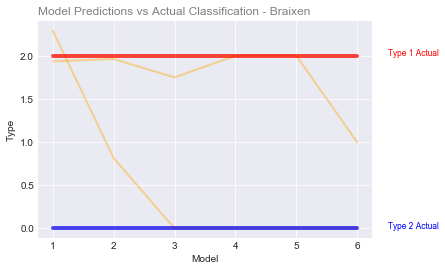

In [86]:
# Now we want to plot our model predictions against the actual results
# The purpose of this is to begin identifying which models do the best at prediction while minimizing processing needed
# Remember, as model depth increases, so does accuracy and processing - we are looking for a "sweet spot"

# Drop Model and Pokemon_Name columns from the DataFrame created above and plot the remaining columns
# I am using the color orange and line width = 0.4, but feel free to tweak the settings to your desire
for column in results.drop(['Model', 'Pokemon_Name'], axis=1):
    plt.plot(results['Model'], results[column], marker='', color='Orange', linewidth=2, alpha=0.4)

# Here we are creating special lines to denote the actual Types
# These lines are different colors and have a higher (thicker) line width
plt.plot(results['Model'], results['Type1_Actual'], marker='', color='Red', linewidth=4, alpha=0.7)
plt.text(6.5, results['Type1_Actual'].tail(1), 'Type 1 Actual', horizontalalignment='left', size='small', color='Red')
plt.plot(results['Model'], results['Type2_Actual'], marker='', color='Blue', linewidth=4, alpha=0.7)
plt.text(6.5, results['Type2_Actual'].tail(1), 'Type 2 Actual', horizontalalignment='left', size='small', color='Blue')

# Add titles and axes labels to the graph
plt.title('Model Predictions vs Actual Classification - {}'.format(results['Pokemon_Name'][0])
          , loc='left', fontsize=12, fontweight=0, color='Grey')
plt.xlabel('Model')
plt.ylabel('Type')

In [91]:
# Now we want to create arrays for each model's predeictions of each Pokemon in our Test DataFrame
# We will initialize 6 arrays and set the ordered Targets that the models will try to match
# Then, we use a for-loop to iterate over the Test DataFrame and run each model on each row
# We then calculate the sum of correct predictions for each model on each row - 
# The model can make correct predictions =  0, 1, or 2, guessing either none, one, or both correct 

model1_results, model2_results, model3_results, model4_results, model5_results, model6_results = [], [], [], [], [], []
targets = np.c_[test['target1'], test['target2']]
counter = 0
for index, row in test.drop(['name', 'target1', 'target2'], axis = 1).iterrows():
    model1_results.append(np.sum(np.array(clf_1.predict(pd.DataFrame(row).transpose()))[0][0] == targets[counter][0]
                                or np.array(clf_1.predict(pd.DataFrame(row).transpose()))[0][0] == targets[counter][1]
                                or np.array(clf_1.predict(pd.DataFrame(row).transpose()))[0][1] == targets[counter][0]
                                or np.array(clf_1.predict(pd.DataFrame(row).transpose()))[0][1] == targets[counter][1]))
    model2_results.append(np.sum(np.array(clf_2.predict(pd.DataFrame(row).transpose()))[0][0] == targets[counter][0]
                                or np.array(clf_2.predict(pd.DataFrame(row).transpose()))[0][0] == targets[counter][1]
                                or np.array(clf_2.predict(pd.DataFrame(row).transpose()))[0][1] == targets[counter][0]
                                or np.array(clf_2.predict(pd.DataFrame(row).transpose()))[0][1] == targets[counter][1]))
    model3_results.append(np.sum(np.array(clf_3.predict(pd.DataFrame(row).transpose()))[0][0] == targets[counter][0]
                                or np.array(clf_3.predict(pd.DataFrame(row).transpose()))[0][0] == targets[counter][1]
                                or np.array(clf_3.predict(pd.DataFrame(row).transpose()))[0][1] == targets[counter][0]
                                or np.array(clf_3.predict(pd.DataFrame(row).transpose()))[0][1] == targets[counter][1]))
    model4_results.append(np.sum(np.array(clf_4.predict(pd.DataFrame(row).transpose()))[0][0] == targets[counter][0]
                                or np.array(clf_4.predict(pd.DataFrame(row).transpose()))[0][0] == targets[counter][1]
                                or np.array(clf_4.predict(pd.DataFrame(row).transpose()))[0][1] == targets[counter][0]
                                or np.array(clf_4.predict(pd.DataFrame(row).transpose()))[0][1] == targets[counter][1]))
    model5_results.append(np.sum(np.array(clf_5.predict(pd.DataFrame(row).transpose()))[0][0] == targets[counter][0]
                                or np.array(clf_5.predict(pd.DataFrame(row).transpose()))[0][0] == targets[counter][1]
                                or np.array(clf_5.predict(pd.DataFrame(row).transpose()))[0][1] == targets[counter][0]
                                or np.array(clf_5.predict(pd.DataFrame(row).transpose()))[0][1] == targets[counter][1]))
    model6_results.append(np.sum(np.array(clf_6.predict(pd.DataFrame(row).transpose()))[0][0] == targets[counter][0]
                                or np.array(clf_6.predict(pd.DataFrame(row).transpose()))[0][0] == targets[counter][1]
                                or np.array(clf_6.predict(pd.DataFrame(row).transpose()))[0][1] == targets[counter][0]
                                or np.array(clf_6.predict(pd.DataFrame(row).transpose()))[0][1] == targets[counter][1]))
    counter = counter + 1

In [92]:
# Here we construct a DataFrame that displays the model classifications for each Pokemon
# With this DataFrame you can look up a Pokemon from the Test set and pull up their classification
# Use the code -> results.loc[results['Pokemon_Name'] == 'Name'] to pull up the classification for the desired Pokemon
# For example, to pull up Tapu Bulu data, use -> results.loc[results['Pokemon_Name'] == 'Tapu Bulu']

results = pd.DataFrame({'Pokemon_Name' : list(test['name']), 'Primary_Type' : list(test['target1']),
                       'Secondary_Type' : list(test['target2']), 'Model1_Result' : list(model1_results),
                       'Model2_Result' : list(model2_results), 'Model3_Result' : list(model3_results),
                       'Model4_Result' : list(model4_results), 'Model5_Result' : list(model5_results),
                       'Model6_Result' : list(model6_results),})
results
#results.loc[results['Pokemon_Name'] == 'Tapu Bulu']  # Tapu Bulu results

,Pokemon_Name,Primary_Type,Secondary_Type,Model1_Result,Model2_Result,Model3_Result,Model4_Result,Model5_Result,Model6_Result
0,Charmander,2,0,0,0,1,1,1,1
1,Pidgeot,5,18,0,0,0,0,0,0
2,Nidoqueen,6,8,0,0,0,1,1,0
3,Poliwrath,3,10,0,0,0,0,0,0
4,Alakazam,11,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...
112,Tapu Lele,11,9,0,0,0,1,1,1
113,Cosmoem,11,0,0,0,0,0,0,0
114,Nihilego,12,6,0,0,0,1,1,1
115,Guzzlord,16,15,0,0,0,0,0,0


In [94]:
# Now we can construct the confusion matrix - a table that describes the accuracy of our classifier models
# Your confusion matrix results will change each time you rerun the program
# For my runs, I noticed that model 5 offered the best accuracy (roughly 30%), even better than model 6
# Model 6 and Model 4 demonstrated similar performance (24.5% and 28.9% respectively), but Model 4 uses 1/4 of the processing
# Remember, that Model 5 has a depth = 2^5 = 32, which will use considerable processing power
# In the end, I'm going to be selecting Model 5 to predict generation 8 Pokemon

total = len(test['target1']) + len(np.where(test['target2'] != 0)[0])
confusion_matrix = pd.DataFrame({'Accuracy' : [sum(results['Model1_Result']) / total, sum(results['Model2_Result']) / total,
                                  sum(results['Model3_Result']) / total, sum(results['Model4_Result']) / total,
                                  sum(results['Model5_Result']) / total, sum(results['Model6_Result']) / total]}, 
                               index = ['Model_1', 'Model_2', 'Model_3', 'Model_4', 'Model_5', 'Model_6'])
confusion_matrix

,Accuracy
Model_1,0.000000
Model_2,0.005464
Model_3,0.114754
Model_4,0.245902
Model_5,0.306011
Model_6,0.289617


In [104]:
# There are not any readily available datasets for generation 8, I'm going to select a single Pokemon and manually load the data
# I am selecting Cinderace, a Fire type
# My model incorrectly predicts (1, 13) = Water/Ghost type
# Feel free to collect your own data and test it
# This concludes this program!
# If you made it this far, thank you for trying and please make any suggestions if you have any
cinderace = pd.DataFrame(['Cinderace', 2, 80, 116, 75, 65, 75, 119, 1.4, 33.0,
              8, 2, 0]).transpose()
clf_5.predict(cinderace.drop([0, 11, 12], axis = 1))

[(nan, 0),
 ('grass', 1),
 ('fire', 2),
 ('water', 3),
 ('bug', 4),
 ('normal', 5),
 ('poison', 6),
 ('electric', 7),
 ('ground', 8),
 ('fairy', 9),
 ('fighting', 10),
 ('psychic', 11),
 ('rock', 12),
 ('ghost', 13),
 ('ice', 14),
 ('dragon', 15),
 ('dark', 16),
 ('steel', 17),
 ('flying', 18)]